<a href="https://colab.research.google.com/github/iskra3138/colab_repo/blob/master/TPUs_in_Colab_from_GCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPUs in Colab&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>
In this example, we'll work through training a model to classify images of
flowers on Google's lightning-fast Cloud TPUs. Our model will take as input a photo of a flower and return whether it is a daisy, dandelion, rose, sunflower, or tulip.

We use the Keras framework, new to TPUs in TF 2.1.0. Adapted from [this notebook](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_xception_fine_tuned_best.ipynb) by [Martin Gorner](https://twitter.com/martin_gorner).

#### License

Copyright 2019-2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose.


## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [0]:
import re
import numpy as np
from matplotlib import pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gcloud projects list

In [0]:
import re

PROJECT = "" #@param {type:"string"}
BUCKET = ""  #@param {type:"string", default:"jddj"}

assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'

In [0]:
!gsutil ls -p {PROJECT}

In [0]:
import os
tfrc_files = os.path.join(BUCKET,'*.tfrec')

In [0]:
### 공개
!gsutil acl ch -u AllUsers:R {tfrc_files}


## Input data

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 230 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.

All of these techniques are a bit overkill for our (small) dataset, but demonstrate best practices for using TPUs.


In [0]:
import os

AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE =  [192, 192]

batch_size = 16 * tpu_strategy.num_replicas_in_sync


gcs_pattern = tfrc_files
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]
        
def parse_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    
    #one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [5])
    return image, one_hot_class

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def get_training_dataset():
  dataset = load_dataset(train_fns)

  # Create some additional training images by randomly flipping and
  # increasing/decreasing the saturation of images in the training set. 
  def data_augment(image, one_hot_class):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    return modified, one_hot_class
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)

  # Prefetch the next batch while training (autotune prefetch buffer size).
  return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO) 

training_dataset = get_training_dataset()
validation_dataset = load_dataset(validation_fns).batch(batch_size).prefetch(AUTO)

Let's take a peek at the training dataset we've created:

In [0]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def display_one_flower(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)
  
# If model is provided, use it to generate predictions.
def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(training_dataset, 9)

In [0]:
# Re-run this cell to show a new batch of images
images, classes = next(training_viz_iterator)

In [0]:
class_idxs = np.argmax(classes, axis=-1) # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_flowers(images, labels)

## Model
To get maxmimum accuracy, we leverage a pretrained image recognition model (here, [Xception](http://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf)). We drop the ImageNet-specific top layers (`include_top=false`), and add a max pooling and a softmax layer to predict our 5 classes.

In [0]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(weights='imagenet', input_shape=[*IMAGE_SIZE, 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()
model.summary()

## Training

Calculate the number of images in each dataset. Rather than actually load the data to do so (expensive), we rely on hints in the filename. This is used to calculate the number of batches per epoch.


In [15]:
def count_data_items(filenames):
  # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
  return np.sum(n)

n_train = count_data_items(train_fns)
n_valid = count_data_items(validation_fns)
train_steps = count_data_items(train_fns) // batch_size
print("TRAINING IMAGES: ", n_train, ", STEPS PER EPOCH: ", train_steps)
print("VALIDATION IMAGES: ", n_valid)

TRAINING IMAGES:  2990 , STEPS PER EPOCH:  23
VALIDATION IMAGES:  680


Calculate and show a learning rate schedule. We start with a fairly low rate, as we're using a pre-trained model and don't want to undo all the fine work put into training it.

Learning rate per epoch:


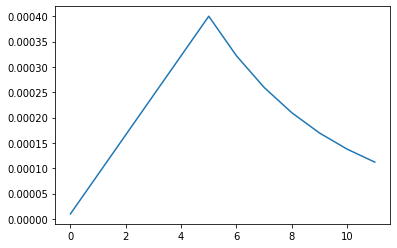

In [16]:
EPOCHS = 12

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

Actually train the model. While the first epoch will be quite a bit slower as we must XLA-compile the execution graph and load the data, later epochs should complete in ~5s.

In [17]:
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=train_steps, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Train for 23 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/12
23/23 [==============================] - 53s 2s/step - loss: 1.5309 - accuracy: 0.3458 - val_loss: 1.3620 - val_accuracy: 0.4956

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/12
23/23 [==============================] - 3s 116ms/step - loss: 0.8866 - accuracy: 0.7520 - val_loss: 0.5412 - val_accuracy: 0.8015

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/12
23/23 [==============================] - 3s 117ms/step - loss: 0.3555 - accuracy: 0.8828 - val_loss: 0.3585 - val_accuracy: 0.8779

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/12
23/23 [==============================] - 3s 114ms/step - loss: 0.1973 - accuracy: 0.9348 - val_loss: 0.2775 - val_accuracy: 0.9000

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/12
23/23 [==============================] - 3s 119m

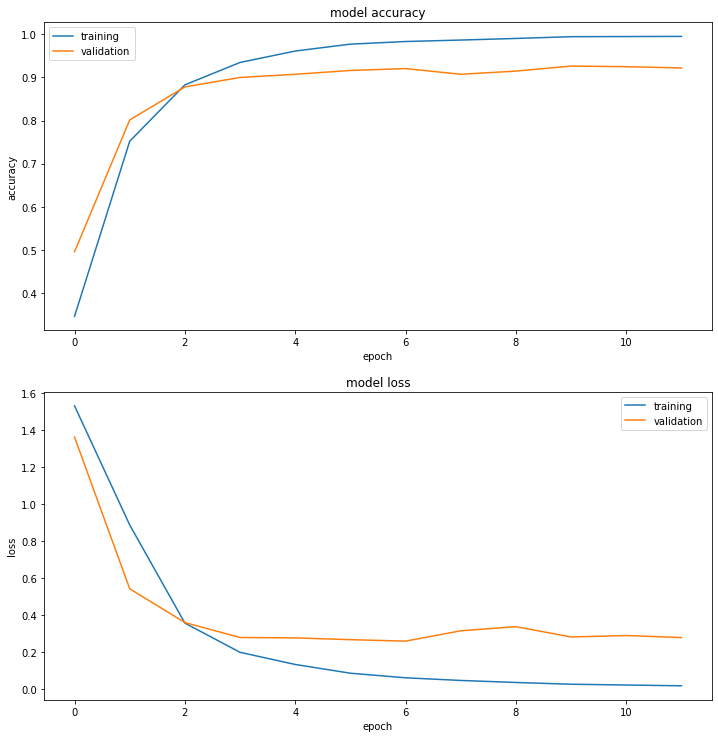

In [18]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Accuracy goes up and loss goes down. Looks good!

## Predictions

Let's look at some our model's predictions next to the original images. We'll show 9 images from the validation set.

In [0]:
def flower_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'black'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = flower_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

validation_viz_iterator = get_dataset_iterator(validation_dataset, 9)

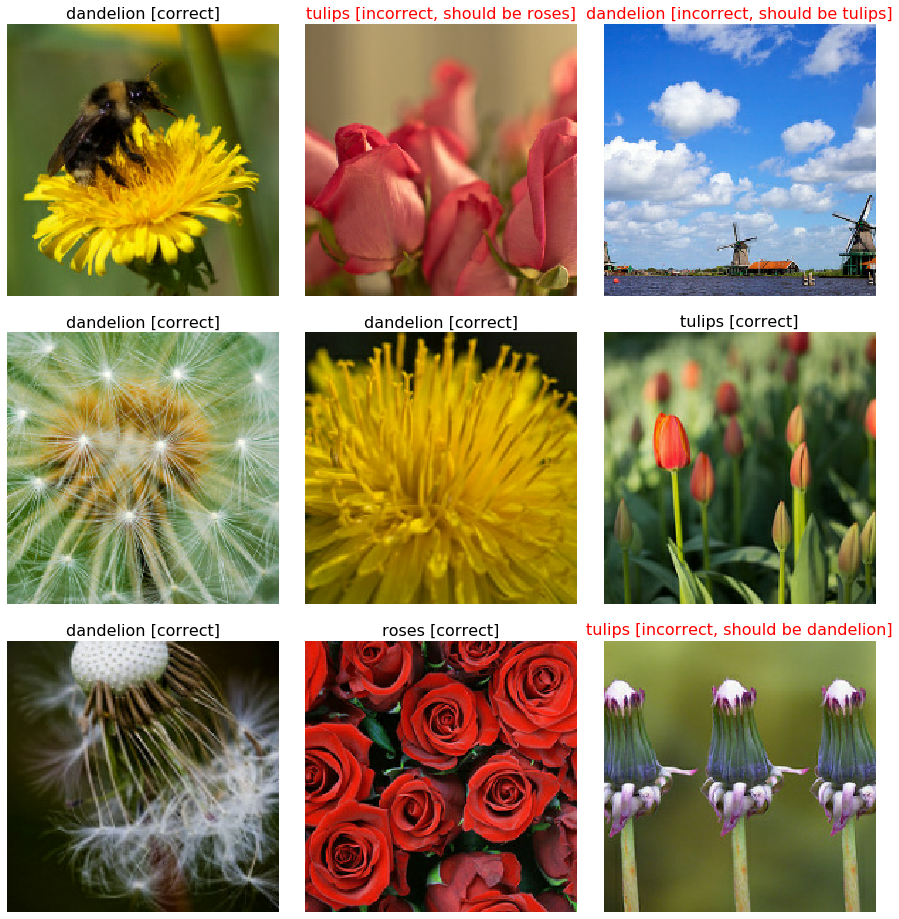

In [20]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, model)
display_nine_flowers(images, titles, colors)

## Save and re-loading our trained model

In [0]:
# We can save our model with:
model.save('model.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model.h5')

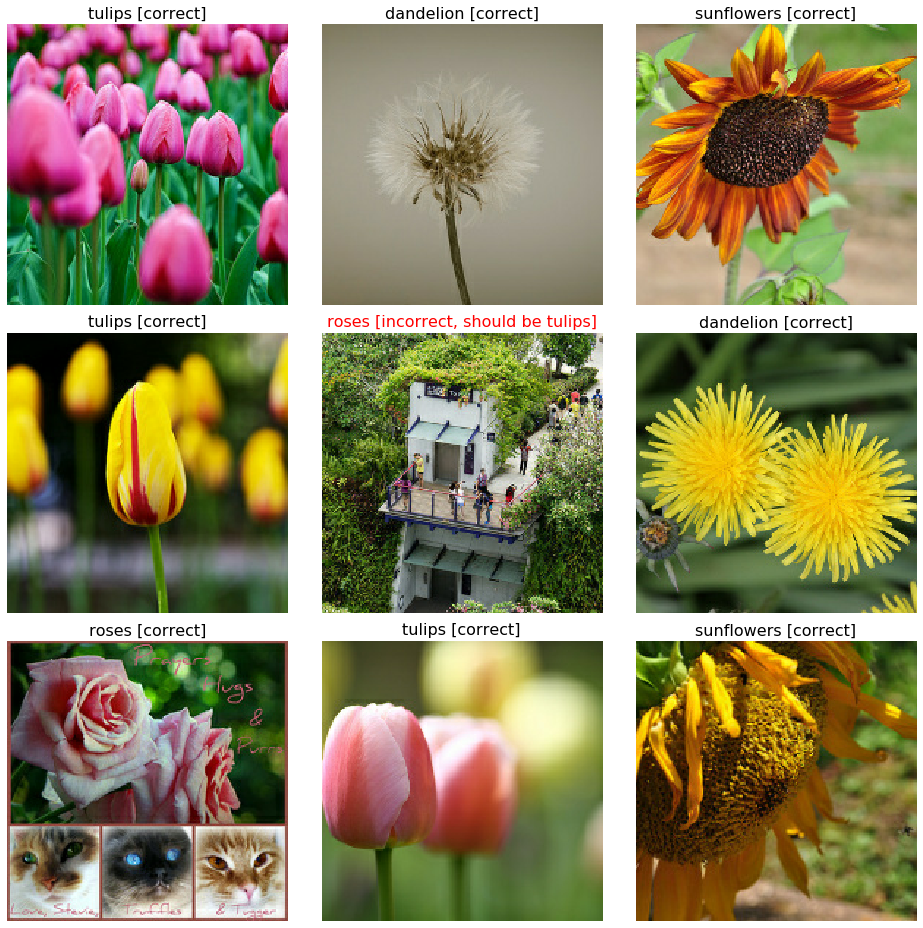

In [22]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, reloaded_model)
display_nine_flowers(images, titles, colors)

In [0]:
### 해제
!gsutil acl ch -d AllUsers {tfrc_files}

## Next steps

More TPU/Keras examples include:
- [Shakespeare in 5 minutes with Cloud TPUs and Keras](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb)
- [Fashion MNIST with Keras and TPUs](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb)

We'll be sharing more examples of TPU use in Colab over time, so be sure to check back for additional example links, or [follow us on Twitter @GoogleColab](https://twitter.com/googlecolab).

https://cloud.google.com/storage/docs/access-control/making-data-public?hl=ko#buckets

https://cloud.google.com/storage/docs/quickstart-gsutil?hl=ko#make_your_object_publicly_accessible